Using TensorFlow backend.


numpy: 1.13.3
keras: 2.0.8
sklearn: 0.19.1


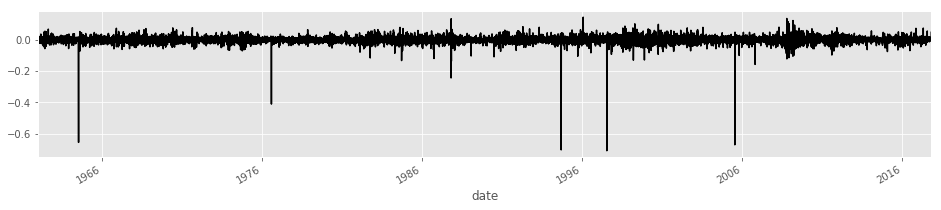

In [1]:
# https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib
import matplotlib.pyplot as plt
from data_prep import load_equity

print('numpy: ' + np.__version__)
print('keras: ' + keras.__version__)
print('sklearn: ' + sklearn.__version__)

matplotlib.style.use('ggplot')

cat_df = load_equity('CAT')

plt.figure(figsize=(16,3))
cat_df['lreturn'].plot(style='k-')
plt.show()

In [2]:
# set window size
lookback_length = 12

# fix random seed for reproducibility
seed = 7

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset(cat_df['lreturn'].values[1:], look_back=lookback_length)
print(X.shape)

# save last 20% as test set
t = int(0.2 * len(X))
X_train, X_test = X[:-t,:], X[-t:,:]
y_train, y_test = y[:-t], y[-t:]
print(len(X_train) + len(X_test))

(14037, 12)
14037


In [12]:
def create_nn_regressor(inputs=8, layers=[8], standardize=False):
    def create_nn():
        model = Sequential()

        model.add(Dense(layers[0], input_dim=inputs, activation='relu'))
        for l in layers[1:]:
            model.add(Dense(l, activation='relu'))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer='adam')
        return model
    
    print(create_nn().summary())
    
    estimator = KerasRegressor(build_fn=create_nn, nb_epoch=100, batch_size=5, verbose=0)
    
    if standardize:
        estimators = []
        estimators.append(('standardize', StandardScaler()))
        estimators.append(('mlp', estimator))
        pipeline = Pipeline(estimators)
        return pipeline

    return estimator
    
def test_model(estimator):
    kfold = KFold(n_splits=3, random_state=seed)
    results = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='r2')
    print("Results: %.4f (%.4f) R2" % (results.mean(), results.std()))
    

In [11]:
# model 1

np.random.seed(seed)

model1 = create_nn_regressor(lookback_length, [24, 24, 24])

test_model(model1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_38 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_39 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 25        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
Results: -0.0060 (0.0026) R2


In [14]:
# model 1 - standardized

np.random.seed(seed)

model1 = create_nn_regressor(lookback_length, [24, 24, 24], True)

test_model(model1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_54 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_55 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 25        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
Results: -0.0636 (0.0326) R2
